In [1]:
# 1) IMPORT PACKAGES

import base64
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import os
import pystac
import requests
import xarray as xr
import rioxarray as rxr
import rasterio as rio
import seaborn as sns
import folium
import sys
import warnings

from datetime import date
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from distutils.command import sdist
from folium import plugins
from matplotlib import pyplot as plt
from pyproj.crs import CRS
from pystac_client import Client
from pprint import pprint
from shapely.geometry import box, mapping, Point, Polygon
from sklearn.linear_model import LinearRegression

# Project specific packages
from FH_Hydrosat import FH_StackedDataset
from FH_Hydrosat import FH_Hydrosat

os.environ['USE_PYGEOS'] = '0'
sys.path.append('../library')
import utils
warnings.filterwarnings('ignore')


In [2]:
# 2) NOTEBOOK FUNCTIONS

# ---------------------------------------------------------------------------------

def stac_tile_search(collection, geom, start_date, end_date):
    """
    Log into STAC and search for a specified image collection.

    Parameters:
    ----------
    collection: list
        List of tiles found in STAC.

    geom: dict
        A dictionary of coordinates defining point location to search.

    start_date, end_date: str
        Dates to search between.

    Returns:
    -------
    found_items: list
        List of images found.
    num_tiles: int
        Num of images found.
    itemjson: json
        Json describing what search found.
    """
    search = catalog.search(
        collections=collection,
        intersects=geom,
        datetime=[start_date, end_date],
        max_items=1000,
    )

    #found_items = list(search.items()) # for pystac-client >= 0.4.0
    found_items = list(search.get_all_items())  # for pystac-client < 0.4.0

    # Need this to get the url path for downloading the files to local machine.
    itemjson = search.item_collection_as_dict() 

    # Filter out only the newest version of MODIS.
    if collection == 'prepped_inputs_mcd43a4':
        version_str = '.061_'
        new_list = [i for i in found_items if version_str in i.id]
        found_items = new_list

    found_items.reverse()  # make the results ascending in time

    num_tiles = len(found_items)
    print("Colllection: {}.  {} Images found.".format(collection, num_tiles))

    return (found_items, num_tiles, itemjson)

# ---------------------------------------------------------------------------------

def create_aoi_image_stack(asset, items, num_tiles, poly_gdf):
    '''
    Gets images, stacks them and sorts them by date and clips them down to a smaller
    AOI size.

    Parameters:
    -----------
    itmes: list 
        List of available images.
    num_tiles: int
        Number of tiles to download (days)
    asset: str
        Name of asset to get.
    poly_gdf: geodataframe
        A polygon to which the dataarray image will be clipped.

    Returns:
    --------
    aoi_stack_ds: dataset as FH_StackedDataset object.
        Stack of images clipped to AOI.

    '''
    images = FH_Hydrosat(items[:num_tiles], asset=asset)

    # Stacks all the files into a dataset and then return a FH_StackedDataset object.
    stacked_images = images.stack()
    # Sort the dataset by time.
    ds = stacked_images.ds.sortby('time')
    
    # Clip the big image into a smaller image using the poly_gdf AOI
    # we defined in the Analysis Setup code cell.
    clipped = FH_StackedDataset(ds.rio.clip(poly_gdf.geometry, all_touched=True, drop=True))
    aoi_stack_ds = clipped.ds

    return (aoi_stack_ds)

# ---------------------------------------------------------------------------------   
def extract_time_series(items, asset, bbox, tol, pad, band, var_name):
    '''
    Uses FH_Hydrosat class method point_time_series_from_items()
    to extract only a time-series.

    Parameters:
    -----------
    items: list
        Image items returned from STAC search.
    bbox: 
        Bounding box of coordinates for seacrh site.
    tol: int
        A search parameter in meters for finding point data.
    var_name: str
        Dataframe column name for data extracted.
    asset: str
        Search parameter for type of asset to be searched.
    
    Returns:
    -------
    lst_df: dataframe
        Dataframe containing date time series.
    '''
    # Sample the LST items.
    lst_res = FH_Hydrosat(items, asset=asset)

    # Set the point for time-series extraction.
    point_wgs84 = Point(box(*bbox).centroid.x, box(*bbox).centroid.y)
    
    # Extract time-series data using function.
    band = int(band) # band needs to be an int because it comes in as a string.
    lst_k  = lst_res.point_time_series_from_items(point_wgs84, tol=tol, nproc=6, band=band) 

    # Create a datetime dataframe
    lst_dt = lst_res.datetime
    lst_df = pd.DataFrame({var_name: lst_k,
                       'datetime': pd.to_datetime(lst_dt)}).sort_values(by='datetime')
    
    # Get the date in the correct/consistent format.
    lst_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in lst_df['datetime']]
    lst_df['date'] = pd.to_datetime(lst_df['date'])
    lst_df.drop(columns='datetime', inplace=True)
    lst_df.set_index('date', drop=True, inplace=True)
    
    return (lst_df)

# --------------------------------------------------------------------------------- 
def read_ameriflux(data_path):
    '''
    Reads, extracts & processes meteorological csv file and returns data in a dataframe.

    Parameters:
    -----------
    data_path: str
        Path to the met datafile
    
    Returns:
    -------
    df: dataframe
        Dataframe containing met time series.
    '''
   
    print('Reading file {}'.format(data_path))

    df = pd.read_csv(data_path, header=0, na_values=[-9999.000000])

    # Save value column names
    value_cols = df.columns[2:]

    # Convert timestamp objects
    df['start'] = df['TIMESTAMP_START'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M.0")
    )
    df['end'] = df['TIMESTAMP_END'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M.0")
    )

    # Convert obs to UTC time.
    # UTC_OFFSET is a global var.
    df['start'] = df['start'] + timedelta(hours=UTC_OFFSET)
    df['end'] = df['end'] + timedelta(hours=UTC_OFFSET)
    df['start'] = df['start'].dt.tz_localize('UTC')
    df['end'] = df['end'].dt.tz_localize('UTC')

    # Drop NA
    df = df.dropna(subset=value_cols, how='all')

    df = df.set_index('start')
    col_order = (['end', 'TIMESTAMP_START', 'TIMESTAMP_END']
                 + value_cols.to_list())
    df = df[col_order]

    return df

# ---------------------------------------------------------------------------------

def write_df_files(df, text):
    """ 
    Writes a dataframe to a csv file.

    Parameters:
    ----------
    df: dataframe
        Dataframe to write to file.
    text: str
        String to add to output file name.
    Returns:
    -------
    file_path: str
        Path to the file so it can be opened later.
    """

    file_name = "{}_{}.csv".format(analysis, text)
    file_path =os.path.join(csv_path, file_name)
    df.to_csv(path_or_buf=file_path, sep=',', na_rep='NA')

    return(file_path)

# ---------------------------------------------------------------------------------
def read_df_files(file_path):
    """ 
    Reads a csv file of a df back into a df. 
    
    Parameters:
    ----------
    file_path: str
        Path to file to open.
    Returns:
    -------
    df: dataframe
        Dataframe of data.
    """

    #file_name = "{}_{}.csv".format(analysis, text)
    #file_path =os.path.join(csv_path, file_name)

    df = pd.read_csv(file_path)
    df.time = pd.to_datetime(df.time, format='mixed')

    return(df)

In [3]:
# 3) STAC LOGIN

# Open credentials file.
with open('../secrets/creds.json') as f:
    creds = json.loads(f.read())

# Endecode the `username:password` combination
# and use it to authorize access to the STAC API given by the `cat_url`
# endpoint.userpass = f"{creds['username']}:{creds['password']}"
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization': 'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

if not catalog.id == 'stac-server':
    print("You have failed to log into the STAC server\n")
else:
    print("You are succesfully logged in to the STAC server and you can now begin STAC queries.\n")


You are succesfully logged in to the STAC server and you can now begin STAC queries.



In [48]:
# 4) ANALYSIS SETUP.  AOI CLIPPING POLYGON CREATED.

# ---------------------------------------------------------------------------
# USER EDITS REQUIRED -------------------------------------------------------
# ---------------------------------------------------------------------------

# Corn field Number.
field_num = 3
analysis = "Corn{}".format(field_num)

# Want met obs in UTC time to match satellites.
UTC_OFFSET = 7

# Set dates for two growing seasons.
start1 = '2022-06-01'
end1 = '2022-09-30'

# Insitu point locations
insitu_met_points = {
    'Corn1': [38.1094, -121.5361],
    'Corn2': [38.1094, -121.5361],
    'Corn3': [38.1094, -121.5361],
    'Corn4': [38.1094, -121.5361],
}

# Center point of crop fields.
crop_center_points = {
    'Corn1': [-121.536114, 38.109538],
    'Corn2': [-121.533, 38.10607],
    'Corn3': [-121.52588, 38.10793],
    'Corn4': [-121.52098, 38.10887], 
}
#'Corn3': [-121.52588, 38.10793],
# Coords for point extraction.
# I.e. For Low NDVI pixels in this analysis.
point_extraction_coords = {
    'Corn1': [-121.535231, 38.108937],
    'Corn2': [-121.533986, 38.105794],
    'Corn3': [-121.5252, 38.1105],
    'Corn4': [-121.5223, 38.11060], 
}

aoi_coordinates = {
    'Corn1': [
        (-121.5352703314288,38.11067012116794),
        (-121.537017491703,38.1103395663037),
        (-121.5370233431901,38.10841814871685),
        (-121.5352318761426,38.10893740470007),
        (-121.5352703314288,38.11067012116794),
   ],
    'Corn2': [
        (-121.5344444486311,38.10287555732225),
        (-121.5314483994475,38.10375752472796),
        (-121.5315333645822,38.10922251872468),
        (-121.5344774233088,38.10830220203034),
        (-121.5344444486311,38.10287555732225),
    ],
    'Corn3': [
        (-121.5272352009598,38.10451747166002),
        (-121.5244507592863,38.10532159430903),
        (-121.5245771824385,38.1114312430658),
        (-121.5273158126795,38.1105671020121),
        (-121.5272352009598,38.10451747166002),
    ],
    'Corn4': [
        (-121.523794568772,38.10500378161704),
        (-121.5178846217463,38.10628347407603),
        (-121.5178930837967,38.11294533147539),
        (-121.5239298740425,38.1113683129804),
        (-121.523794568772,38.10500378161704),
    ],
}
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------

# Define path to met data
data_path = os.path.join('../data', 'Ameriflux')

# Define path to local/temp output data file.
csv_path = os.path.join('./out')
if not os.path.exists(csv_path):
    os.mkdir('./out')
    
if analysis == 'Corn1':
    
    bbox = [
        aoi_coordinates[analysis][0][0], aoi_coordinates[analysis][0][1], 
        aoi_coordinates[analysis][3][0], aoi_coordinates[analysis][3][1]
        ]

    # Manually defined point location of the pixel showing lower ndvi (stress)
    p_geom = Point(point_extraction_coords[analysis])

    met_path = os.path.join(data_path,
                            'US-Bi2_HH_201704270000_202301010000.csv')
    
    aoi = aoi_coordinates['Corn1']
    poly = Polygon(aoi)
    poly_gdf = gpd.GeoDataFrame({'geometry': [poly]}, crs=CRS.from_epsg(4326))
    poly_gdf = poly_gdf.to_crs(crs=CRS.from_epsg(32610))

    if not os.path.exists(data_path):
        print("You do not have the required Ameriflux data file for a {} analysis".format(
            analysis))
        
elif analysis == 'Corn2':

    bbox = [
        aoi_coordinates[analysis][0][0], aoi_coordinates[analysis][0][1], 
        aoi_coordinates[analysis][3][0], aoi_coordinates[analysis][3][1]
        ]

    # Manually defined point location of the pixel showing lower ndvi (stress)
    p_geom = Point(point_extraction_coords[analysis])

    met_path = os.path.join(data_path,
                            'US-Bi2_HH_201704270000_202301010000.csv')
    
    aoi = aoi_coordinates['Corn2']
    poly = Polygon(aoi)
    poly_gdf = gpd.GeoDataFrame({'geometry': [poly]}, crs=CRS.from_epsg(4326))
    poly_gdf = poly_gdf.to_crs(crs=CRS.from_epsg(32610))

    if not os.path.exists(data_path):
        print("You do not have the required Ameriflux data file for a {} analysis".format(
            analysis))

elif analysis == 'Corn3':

    bbox = [
        aoi_coordinates[analysis][0][0], aoi_coordinates[analysis][0][1], 
        aoi_coordinates[analysis][3][0], aoi_coordinates[analysis][3][1]
        ]
    
    # Manually defined point location of the pixel showing lower ndvi (stress)
    p_geom = Point(point_extraction_coords[analysis])

    met_path = os.path.join(data_path,
                            'US-Bi2_HH_201704270000_202301010000.csv')
    
    aoi = aoi_coordinates['Corn3']
    poly = Polygon(aoi)
    poly_gdf = gpd.GeoDataFrame({'geometry': [poly]}, crs=CRS.from_epsg(4326))
    poly_gdf = poly_gdf.to_crs(crs=CRS.from_epsg(32610))

    if not os.path.exists(data_path):
        print("You do not have the required Ameriflux data file for a {} analysis".format(
            analysis))

elif analysis == 'Corn4':

    bbox = [
        aoi_coordinates[analysis][0][0], aoi_coordinates[analysis][0][1], 
        aoi_coordinates[analysis][3][0], aoi_coordinates[analysis][3][1]
        ]
    
    # Manually defined point location of the pixel showing lower ndvi (stress)
    p_geom = Point(point_extraction_coords[analysis])

    met_path = os.path.join(data_path,
                            'US-Bi2_HH_201704270000_202301010000.csv')
    
    aoi = aoi_coordinates['Corn4']
    poly = Polygon(aoi)
    poly_gdf = gpd.GeoDataFrame({'geometry': [poly]}, crs=CRS.from_epsg(4326))
    poly_gdf = poly_gdf.to_crs(crs=CRS.from_epsg(32610))

    if not os.path.exists(data_path):
        print("You do not have the required Ameriflux data file for a {} analysis".format(
            analysis))
                
# Create dict of coords.  Will be used to create a polygon for our AOI.
geom = {'type': 'Point', 'coordinates': crop_center_points[analysis]}

# -------------------------------------------------------------------
# -------------------------------------------------------------------

asset_dict = {
    "prepped_inputs_mod21a1d": ['mod21a1d_lst', 2000, 1000, 'brown'],
    "pydms_sharpened_modis": ['pydms_modis_lst', 1000, 500, 'green'],
    "prepped_inputs_landsat": ['lsat_lst', 60, 30, 'black'],
    "pydms_sharpened_landsat": ['pydms_lsat_lst', 40, 20, 'blue'],
    "starfm_predictions_modis_landsat": ['starfm_lst', 40, 20, 'red'],
}

print("Analysis setup comlete.\n")

Analysis setup comlete.



In [5]:
# 5) FOLIUM MAP OF AOI.

p_geom = Point(geom['coordinates'][0], geom['coordinates'][1])

m = folium.Map(location=[p_geom.y, p_geom.x], zoom_start=15,
               tiles='CartoDB positron', control_scale=True)

# ---------------------------------
# Use satellite image for base map.
tile = folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(m)
# ---------------------------------

# add the polygon and centroid
df = poly_gdf.to_crs(epsg=4326)

for _, r in df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    geo_j.add_to(m)
m

In [6]:
# 6) SENTINEL & MODIS IMAGE SEARCH

collections = ["prepped_inputs_s2"]

# Search STAC for available images.
(s2_items, num_s2_tiles, itemjson) = stac_tile_search("prepped_inputs_s2", geom, start1, end1)
(mcd43a4_items, num_mcd43a4_tiles, itemjson) = stac_tile_search("prepped_inputs_mcd43a4", geom, start1, end1)

# Print out the first and last dates of the found items (images).
print(f"First S2 date: {s2_items[0]}")
print(f"Last S2 date: {s2_items[-1]}")

print(f"First MCD date: {mcd43a4_items[0]}")
print(f"Last MCD date: {mcd43a4_items[-1]}")

Colllection: prepped_inputs_s2.  25 Images found.
Colllection: prepped_inputs_mcd43a4.  36 Images found.
First S2 date: <Item id=S2_10SFH_median_composite_20220606>
Last S2 date: <Item id=S2_10SFH_median_composite_20220924>
First MCD date: <Item id=MCD43A4.061_20220822_10SFH>
Last MCD date: <Item id=MCD43A4.061_20220930_10SFH>


In [7]:
#* 7) EXTRACT SENTINEL2 INTO DATAARRAYS & COMPUTE NDVI

# Sentinel 2 --------------------------------------------------------

# Get images from stack.
(aoi_stack_ds) = create_aoi_image_stack(
    'surface_reflectance', s2_items, num_s2_tiles, poly_gdf)

# Pull out NIR and Red bands.
red_aoi_ds = aoi_stack_ds.isel(band=2)
nir_aoi_ds = aoi_stack_ds.isel(band=6)

# Compute NDVI.
ndvi_s2_aoi_ds = (nir_aoi_ds - red_aoi_ds) / (nir_aoi_ds + red_aoi_ds)

# Modis --------------------------------------------------------------

# Get images from stack
(aoi_stack_ds) = create_aoi_image_stack(
    'surface_reflectance', mcd43a4_items, num_mcd43a4_tiles, poly_gdf)

# Pull out NIR and Red bands.
red_aoi_mcd_ds = aoi_stack_ds.isel(band=0)
nir_aoi_mcd_ds = aoi_stack_ds.isel(band=1)

# Compute NDVI.
ndvi_aoi_mcd_ds = (nir_aoi_mcd_ds - red_aoi_mcd_ds) / (nir_aoi_mcd_ds + red_aoi_mcd_ds)

In [ ]:
# 8) PLOT SENTINEL 2 DATARRAY IMAGES OF NDVI MEAN & VARIANCE

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5))

# Convert our slice time endpoints to compatabile format.
d1 = pd.to_datetime('2022-07-01', utc=True)
d2 = pd.to_datetime('2022-07-31', utc=True)

# The point location of the pixel showing lower ndvi (stress).
point_df = gpd.GeoDataFrame({'geometry':[p_geom]}, crs=CRS.from_epsg(4326))
raster_crs = CRS.from_wkt(ndvi_s2_aoi_ds.spatial_ref.crs_wkt)
buffer_dist = 20 # 1km in local UTM zone
point_poly_df = point_df.to_crs(raster_crs).buffer(buffer_dist, cap_style = 3) # square buffer
centroid = point_poly_df.geometry[0].centroid
point_x, point_y = (centroid.x, centroid.y)

# Select slices, compute stats, and plot.
# Mean and Variance.
a = ndvi_s2_aoi_ds.sel(time=slice(d1,d2)).mean(dim='time').plot(ax=ax1)
b = ndvi_s2_aoi_ds.sel(time=slice(d1,d2)).var(dim='time').plot(ax=ax2)

# Adjust plot elements.

ax1.set_title('Mean of Sentinel 2 NDVI')
ax2.set_title('Variance of Sentinel 2 NDVI')
title = "Sentinel 2 Mean NDVI July 1-31, 2022\nCorn Field {}".format(field_num)
fig.suptitle(title, fontsize='12')

# Plot a point where ndvi is lower.  Will later extract point data here.
ax1.plot(point_x, point_y, markersize=15, marker=".", color="m")
ax2.plot(point_x, point_y, markersize=15, marker=".", color="m")

ax1.set_yticklabels('')
ax2.set_yticklabels('')

ax1.set_xticklabels('')
ax2.set_xticklabels('')

ax1.set_xlabel('')
ax2.set_xlabel('')

ax1.set_ylabel('')
ax2.set_ylabel('')

plt.tight_layout()

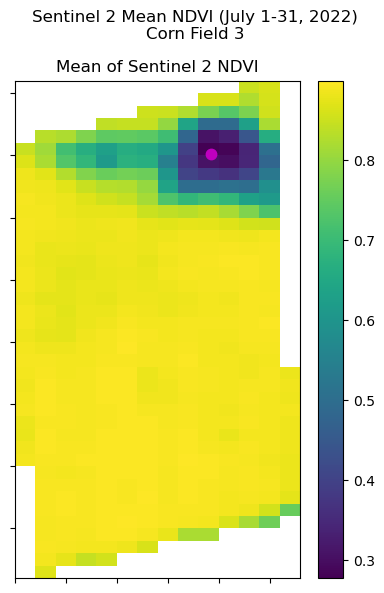

In [49]:
# 8) PLOT ONLY SENTINEL 2 DATARRAY IMAGE OF NDVI MEAN

fig, (ax1) = plt.subplots(1,1, figsize=(4,6))

# Convert our slice time endpoints to compatabile format.
d1 = pd.to_datetime('2022-07-01', utc=True)
d2 = pd.to_datetime('2022-07-31', utc=True)

# The point location of the pixel showing lower ndvi (stress).
point_df = gpd.GeoDataFrame({'geometry':[p_geom]}, crs=CRS.from_epsg(4326))
raster_crs = CRS.from_wkt(ndvi_s2_aoi_ds.spatial_ref.crs_wkt)
buffer_dist = 20 # 1km in local UTM zone
point_poly_df = point_df.to_crs(raster_crs).buffer(buffer_dist, cap_style = 3) # square buffer
centroid = point_poly_df.geometry[0].centroid
point_x, point_y = (centroid.x, centroid.y)

# Select slices, compute stats, and plot.
# Mean and Variance.
a = ndvi_s2_aoi_ds.sel(time=slice(d1,d2)).mean(dim='time').plot(ax=ax1)
# Plot a point where ndvi is lower.  Will later extract point data here.
ax1.plot(point_x, point_y, markersize=15, marker=".", color="m")

# Adjust plot elements.

ax1.set_title('Mean of Sentinel 2 NDVI')
title = "Sentinel 2 Mean NDVI (July 1-31, 2022)\nCorn Field {}".format(field_num)
fig.suptitle(title, fontsize='12')

ax1.set_yticklabels('')
ax2.set_yticklabels('')
ax1.set_xticklabels('')
ax2.set_xticklabels('')
ax1.set_xlabel('')
ax1.set_ylabel('')

plt.tight_layout()

In [10]:
# 9) CONVERT SENTINEL 2 TO DATAFRAME, RESAMPLE & WRITE TO FILE.

# Resampling simplifies the timestamp in that it removes the hours and minutes 
# and makes each day's dt consistent.  In addition, resampling fills in missing dates 
# with NA which will help with plotting consistency.

# Sentinel 2 ------------------------------------------------------
# Convert dataaset to a dataframe.
s2_ndvi_df = ndvi_s2_aoi_ds[0:24,:,:].to_dataframe(name='s2_ndvi')
# Drop uneeded columns.
s2_ndvi_df.drop(columns=['spatial_ref'], inplace=True)
# Convert multilevel index to single level.
s2_ndvi_df = s2_ndvi_df.reset_index(level=[1, 2])
# Put index into dt64 format.
s2_ndvi_df.index = pd.to_datetime(s2_ndvi_df.index)
# Resample to just the y-m-d and take the mean() which in this case
# will be the mean ndvi for the AOI.
s2_ndvi_resampled_df = s2_ndvi_df.groupby(['x','y']).resample('D', origin=pd.to_datetime(start1, utc=s2_ndvi_df.index.tz)).mean()
# s2_ndvi_mean_df = s2_ndvi_df.resample('D').mean()  # NExt cell instead.
# Drop uneeded cols and make a single index instead of multi.
s2_ndvi_resampled_df.drop(columns=['y','x'], inplace=True)
s2_ndvi_resampled_df = s2_ndvi_resampled_df.reset_index(level=[0, 1])
# Resort so that rows are chronologically grouped.
s2_ndvi_resampled_sort_df = s2_ndvi_resampled_df.sort_index()

# CREATE DATAFRAMES OF MEAN SENTINEL 2 AND MODIS NDVI.
s2_ndvi_mean_df = s2_ndvi_resampled_df.groupby(['time']).resample('D', origin=pd.to_datetime(start1, utc=s2_ndvi_df.index.tz)).mean()
s2_ndvi_mean_df.rename(columns={"s2_ndvi": "s2_mean_ndvi"}, inplace=True)
s2_ndvi_mean_df = s2_ndvi_mean_df.reset_index(level=[1])
s2_ndvi_mean_df.index = pd.to_datetime(s2_ndvi_mean_df.time)

# Write dataframe to a file so that we dont have to 
# convert the dataarrays every time.
#file_name = "{}_s2_ndvi_aoi_csv".format(analysis)
#ndvi_csv_aoi_path =os.path.join(csv_path, file_name)
#s2_ndvi_resampled_sort_df.to_csv(path_or_buf=ndvi_csv_aoi_path, sep=',', na_rep='NA')
#
#file_name = "{}_s2_ndvi_mean_csv".format(analysis)
#ndvi_csv_mean_path =os.path.join(csv_path, file_name)
#s2_ndvi_mean_df.to_csv(path_or_buf=ndvi_csv_mean_path, sep=',', na_rep='NA')

# Write dataframes to csv files.
ndvi_aoi_path = write_df_files(s2_ndvi_resampled_sort_df, 's2_ndvi_aoi')
ndvi_mean_path = write_df_files(s2_ndvi_mean_df, 's2_ndvi_mean')

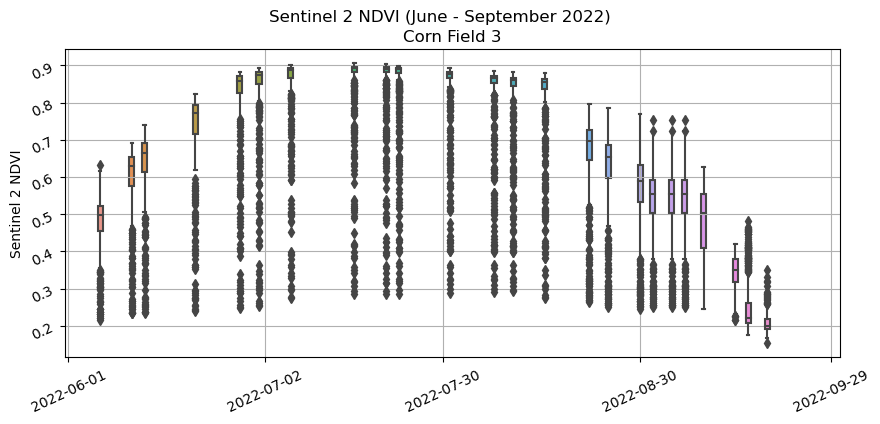

In [11]:
# 11) CREATE AOI BOXPLOT OF SENTINEL2 NDVI AOI PIXELS.

# READ CSV OUTPUT FILES INTO NDVI DF
# Pass the file path returned by the write_df_files() function.
file_name = "{}_{}.csv".format(analysis, 's2_ndvi_aoi')
ndvi_aoi_path =os.path.join(csv_path, file_name)
s2_ndvi_resampled_df = read_df_files(ndvi_aoi_path)

file_name = "{}_{}.csv".format(analysis, 's2_ndvi_mean')
ndvi_mean_path =os.path.join(csv_path, file_name)
s2_ndvi_mean_df = read_df_files(ndvi_mean_path)

# Get rid of the time/hours from the date.
s2_ndvi_resampled_df.time = pd.to_datetime(s2_ndvi_resampled_df.time, format='mixed').dt.date
# For some reason the time has to be converted again to get a dt object.
s2_ndvi_resampled_df.time = pd.to_datetime(s2_ndvi_resampled_df.time)

s2_ndvi_mean_df.time = pd.to_datetime(s2_ndvi_mean_df.time, format='mixed').dt.date
# For some reason the time has to be converted again to get a dt object.
s2_ndvi_mean_df.time = pd.to_datetime(s2_ndvi_mean_df.time)

# Fill in missing start dates so we can start from the 1st of the month.
dates = pd.date_range(start=start1, end=end1).to_frame()
s2_ndvi_resampled_df = pd.merge(
    s2_ndvi_resampled_df, dates, left_on='time', right_on=0,
    how='outer').sort_values(by=['time']).drop(columns=0)

# Create plot.
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 4))

fig.suptitle('Sentinel 2 NDVI (June - September 2022)', fontsize='12')

# Make box plots.
title = "Corn Field {}".format(field_num)
box = (
    sns.boxplot(
    x=s2_ndvi_resampled_df['time'].apply(lambda x: x.strftime('%Y-%m-%d')),
    #x=s2_ndvi_resampled_df['time'].strftime('%Y-%m-%d'),
    y=s2_ndvi_resampled_df['s2_ndvi'],
    ax=ax1)
    .set(title=title),
    )

ax1.set_ylabel('Sentinel 2 NDVI')
ax1.set_xlabel('')

ax1.xaxis.set_major_locator( mdates.DayLocator( bymonthday=1) )
ax1.tick_params(labelrotation=25)

ax1.grid()

### Section 2:  Get meteorology & Plot

In [12]:
#* 12) GET METEOROLOGY INTO DATAFRAME FOR CATD CALCS.

# Will use met_df in next code cell.
met_df = read_ameriflux(met_path)


Reading file ../data/Ameriflux/US-Bi2_HH_201704270000_202301010000.csv


### Section 3: Extract LST, Compute CATD, and Plot.

In [13]:
#* 13) EXTRACT AOI LST DATARRAY.  COMPUTE CATD & CREAT CATD DATARRAYS.

# Dictionary keys are: var_name, tolerance, resolution, plot color.
#     var_name: used as column name in dataframe.
#     tolerance (m): search parameter in meters for extracting point data.
#     resolution (m): this is the legend when plotting
#     plot color: for plotting

# See https://hydrosat.github.io/fusion-hub-docs/3-FH-API-Spec.html
# for asset specifications.

# prepped_inputs_landsat = resampled to 30 m
# prepped_inputs_mod21a1d = 1000 m
# pydms_sharpened_modis = 500 m
# pydms_sharpened_landsat = downscaled to 20 m
# starfm_predictions_modis_landsat = 20 m

# ---------------------------------------------------------------------------
# USER EDITS POSSIBLE -------------------------------------------------------
# ---------------------------------------------------------------------------

asset_dict = {
    "prepped_inputs_mod21a1d": ['mod21a1d_lst', 2000, 1000, 'brown'],
    "pydms_sharpened_modis": ['pydms_modis_lst', 1000, 500, 'green'],
    "prepped_inputs_landsat": ['lsat_lst', 60, 30, 'black'],
    "pydms_sharpened_landsat": ['pydms_lsat_lst', 40, 20, 'blue'],
    "starfm_predictions_modis_landsat": ['starfm_lst', 40, 20, 'red'],
}
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------

catd_list = [] # A list that will hold single timestep da's of catd.
lst_da_list = []  # A list holding each collections LST dat.
catd_da_list = []  #  Alist holding each collections catd dat.
ta_list = []
rh_list = []
ws_list = []

# Loop through the dictionary.
for i, asset in enumerate(asset_dict):

    # Just to make sure these lists get reset after each loop iteration.
    found_items = []

    (found_items, num_tiles, itemjson) = stac_tile_search(asset, geom, start1, end1)
    
    # Extract LST data from AOI. ----------------
    (aoi_lst_da) = create_aoi_image_stack(
            'lst', found_items, num_tiles, poly_gdf)

    # Want to process each timesteps CATD so we iterate through
    # time and work with a single dimension at at time.
    for date, aoi in aoi_lst_da.groupby('time'):

        # The obs time for STARFM is 10:30 local time.  
        # We need to search the met for this time.  
        # The timestamp for the LST dataarrays only has y,m,d.
        # So, we need to take the y, m, d and add the hour and minutes.
        t = pd.to_datetime(date)
        search_time = pd.to_datetime({
                            'year': [t.year],
                            'month': [t.month],
                            'day': [t.day],
                            'hour': [17],
                            'minute': [30]},
                            utc='true')

        # Get TA from dataframe using each time step (date).
        ta = met_df.TA.iloc[met_df.index.get_indexer([search_time[0]], method='nearest')]
        rh = met_df.RH.iloc[met_df.index.get_indexer([search_time[0]], method='nearest')]
        ws = met_df.WS.iloc[met_df.index.get_indexer([search_time[0]], method='nearest')]

        # Here we want to collect the met params for each timestep
        # of the LST dataarrays.  We'll use these to plot up the
        # et later on.
        if asset == 'starfm_predictions_modis_landsat':
            ta_list.append(ta)
            rh_list.append(rh)
            ws_list.append(ws)
            
        # Convert from C to K.
        ta = ta + 273.15
        # Compute CATD.  Subtract the TA value from each AOI pixel.
        catd = aoi - ta.values
        # Append new CATD da to a list.
        catd_list.append(catd)

    # After each date has been computed.  Concatenate them all together.
    catd_ds = xr.concat(catd_list, coords='minimal', dim='time', compat='override').squeeze()
    # Done with the current CATD list so reset for next asset.
    catd_list = []
    
    catd_da_list.append(catd_ds)
    lst_da_list.append(aoi_lst_da.squeeze())

# Here we concat together the list of datetime df's that we created/collected above.
ta_df = pd.concat(ta_list)
rh_df = pd.concat(rh_list)
ws_df = pd.concat(ws_list)

Colllection: prepped_inputs_mod21a1d.  122 Images found.
Colllection: pydms_sharpened_modis.  158 Images found.
Colllection: prepped_inputs_landsat.  30 Images found.
Colllection: pydms_sharpened_landsat.  30 Images found.
Colllection: starfm_predictions_modis_landsat.  92 Images found.


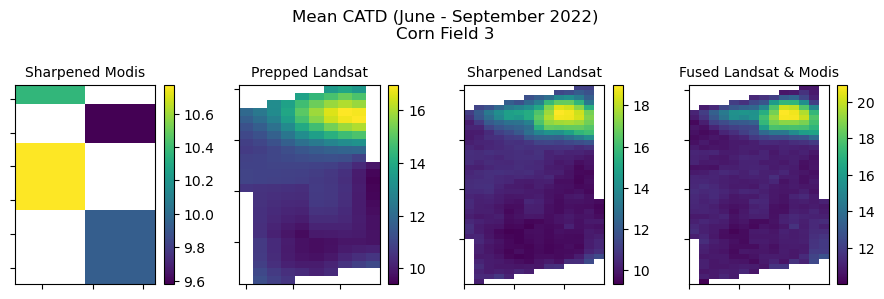

In [14]:
# 14) PLOT ASSET AOI DATAARRAY IMAGES OF CATD MEAN & VARIANCE

fig, (ax2, ax3, ax4, ax5) = plt.subplots(1,4, figsize=(9,3))

# Select slices, compute mean, and plot.

# Noted catd_da_list[0] is 1000m Modis so only once cell is extracted for the AOI.  
# This means there is one less dimension compared to the other assets.  You can 
# view the dimensions by printing out catd_da_list[0] vs catd_da_list[1].
#a = catd_da_list[0][:,:].mean(dim='time').plot(ax=ax1)
b = catd_da_list[1][:,:,:].mean(dim='time').plot(ax=ax2)
c = catd_da_list[2][:,:,:].mean(dim='time').plot(ax=ax3)
d = catd_da_list[3][:,:,:].mean(dim='time').plot(ax=ax4)
e = catd_da_list[4][:,:,:].mean(dim='time').plot(ax=ax5)

# Adjust plot elements.

title = "Mean CATD (June - September 2022)\nCorn Field {}".format(field_num)
fig.suptitle(title)

ax2.set_title('Sharpened Modis')
ax3.set_title('Prepped Landsat')
ax4.set_title('Sharpened Landsat')
ax5.set_title('Fused Landsat & Modis')

ax2.title.set_size(10)
ax3.title.set_size(10)
ax4.title.set_size(10)
ax5.title.set_size(10)

ax2.set_yticklabels('')
ax3.set_yticklabels('')
ax4.set_yticklabels('')
ax5.set_yticklabels('')

ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax4.set_xticklabels('')
ax5.set_xticklabels('')

ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel('')

ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')

plt.tight_layout()

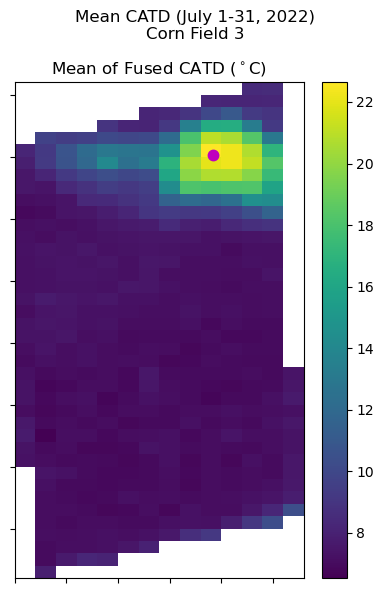

In [51]:
# 14) PLOT STARFM AOI DATAARRAY IMAGES OF CATD MEAN & VARIANCE

fig, (ax5) = plt.subplots(1,1, figsize=(4,6))

# Select slices, compute mean, and plot.
# Convert our slice time endpoints to compatabile format.
d1 = pd.to_datetime('2022-07-01')
d2 = pd.to_datetime('2022-07-31')

# Noted catd_da_list[0] is 1000m Modis so only once cell is extracted for the AOI.  
# This means there is one less dimension compared to the other assets.  You can 
# view the dimensions by printing out catd_da_list[0] vs catd_da_list[1].
#e = catd_da_list[4][:,:,:].mean(dim='time').plot(ax=ax5, label='CATD (Degrees C)')
e = catd_da_list[4].sel(time=slice(d1,d2)).mean(dim='time').plot(ax=ax5, label='CATD (Degrees C)')
ax5.plot(point_x, point_y, markersize=15, marker=".", color="m")
# Adjust plot elements.

title = "Mean CATD (July 1-31, 2022)\nCorn Field {}".format(field_num)
fig.suptitle(title)

ax5.set_title("Mean of Fused CATD ($^\circ$C)")
ax5.set_yticklabels('')
ax5.set_xticklabels('')
ax5.set_xlabel('')
ax5.set_ylabel('')

plt.tight_layout()

In [17]:
# 15) CONVERT AOI CATD DATAARRAYS INTO DATAFRAMES & WRITE TO FILES.

# Lists to hold datframes for each asset
lst_df_list = []
catd_df_list = []
i=0

# Loop through the dictionary.
for i, asset in enumerate(asset_dict):

    print (asset)

    # Name the columns to hold catd.
    catd_col_name = "{}_{}_catd".format(analysis, asset)
    catd_df = catd_da_list[i].to_dataframe(name=catd_col_name)
    
    # Get rid of unneeded columns. --------
    if asset == 'prepped_inputs_mod21a1d':
        catd_df.reset_index(level=[1], inplace=True)
    else:
        catd_df.reset_index(level=[1, 2], inplace=True)

    # Resampling fills in dates that dont exist in the data.
    catd_resampled_df = catd_df.groupby(['x','y']).resample('D').mean()
    catd_resampled_df = catd_resampled_df.droplevel([0,1])

    # Re-sort so that rows are chronologically grouped.
    catd_resampled_df.sort_index(inplace=True)

    # Write dfs to files.
    text = "{}_catd_aoi".format(asset)
    catd_aoi_path = write_df_files(catd_resampled_df, text)

    # Create a list of dataframes.
    catd_df_list.append(catd_resampled_df)

prepped_inputs_mod21a1d
pydms_sharpened_modis
prepped_inputs_landsat
pydms_sharpened_landsat
starfm_predictions_modis_landsat


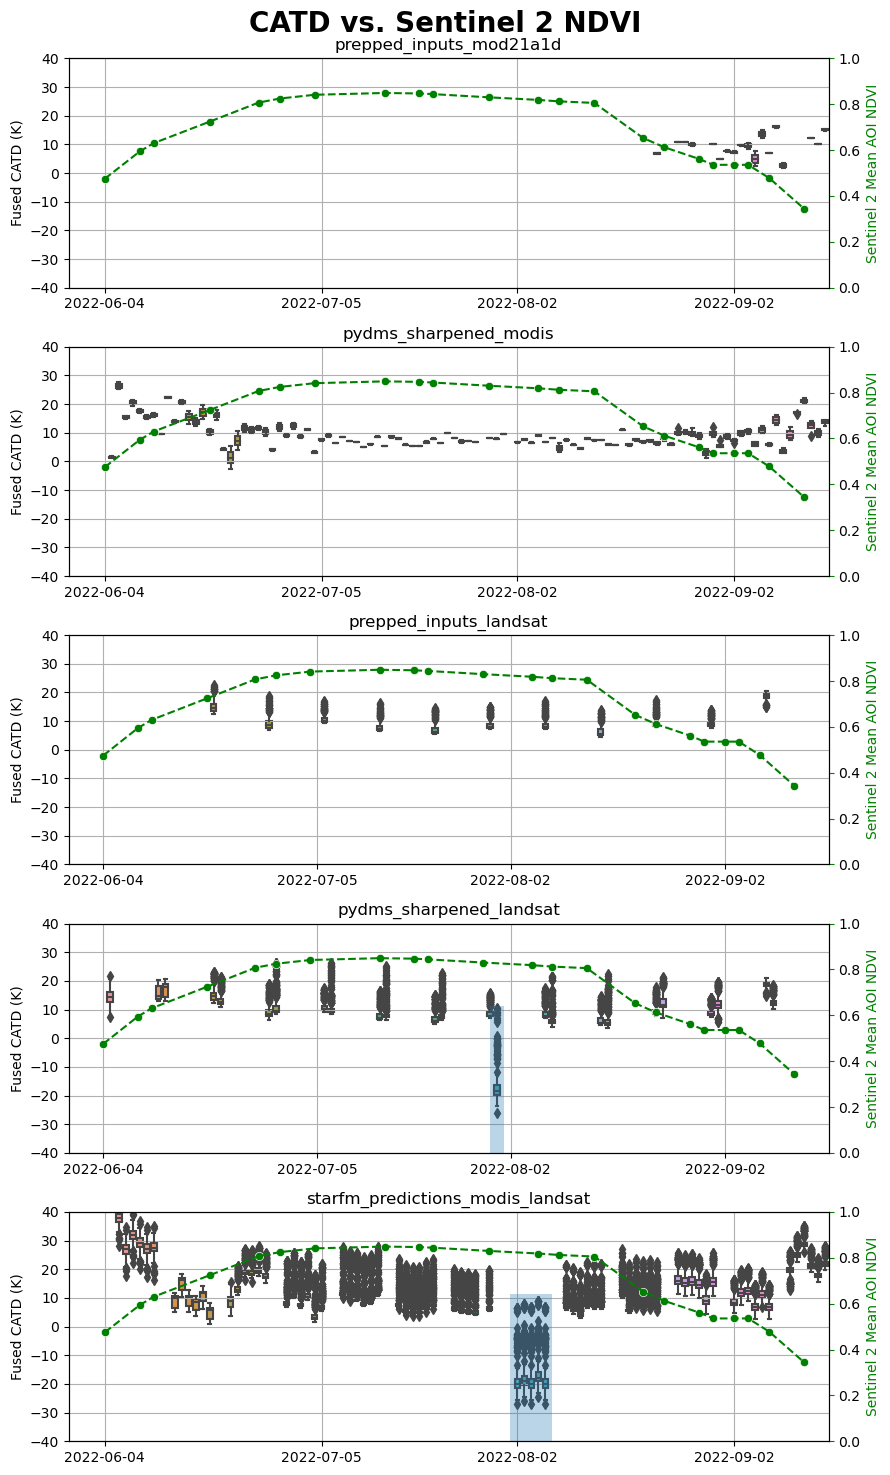

In [18]:
# 16) AOI ANNUAL BOXPLOTS OF CATD

# Create a figure.  Axes will be created in the loop.
fig = plt.figure(figsize=(9, 15))
plt.subplots_adjust(hspace=0.5)

fig.suptitle('CATD vs. Sentinel 2 NDVI', weight='bold', fontsize=20)

# Create a counter for getting the number of axes correct.
j = 0

# Loop through each collection in the dictionary.
for i, asset in enumerate(asset_dict):

    # Get the dataframe out of the list but will skip the two MODIS
    # dataframes because there is only mid-august and on data.
    #if i <= 1: continue

    # READ CSV OUTPUT FILES INTO NDVI DF

    file_name = "{}_{}_catd_aoi.csv".format(analysis, asset)
    file_path =os.path.join(csv_path, file_name)
    df_new_catd = read_df_files(file_path)

    # Set index to time.
    df_new_catd.index = df_new_catd['time']
    s2_ndvi_mean_df.index = s2_ndvi_mean_df['time']

    # Make box plots. --------------------

    # Create an axes dynamically.  
    ax = plt.subplot(5, 1, j + 1)
    # Increment the axes number up one after each valid dataset.
    j = j + 1
    # Create a twin axes for catd and ndvi.
    twinax0 = ax.twinx()

    # If statements catch any empty dataframes and doesnt try to plot them up.
    if df_new_catd['2022-06-01':'2022-09-15'].size > 0:

        catd_col_name = "{}_{}_catd".format(analysis, asset)

        # Plot CATD.
        (sns.boxplot(
                x=df_new_catd['2022-06-04':'2022-09-15'].index.strftime('%Y-%m-%d'),
                y=df_new_catd['2022-06-04':'2022-09-15'][catd_col_name],
                ax=ax)
        .set(title="{}".format(asset))
        )
                
        # Plot daily mean NDVI as points.
        (sns.scatterplot(
                x=s2_ndvi_mean_df['2022-06-04':'2022-09-15'].index.strftime('%Y-%m-%d'),
                y=s2_ndvi_mean_df['2022-06-04':'2022-09-15']['s2_mean_ndvi'], 
                ax=twinax0, color='green')
        )
                
        # Plot daily mean NDVI as a dashed line in addition to the points.
        (sns.lineplot(
                x=s2_ndvi_mean_df['2022-06-04':'2022-09-15'].index.strftime('%Y-%m-%d'),
                y=s2_ndvi_mean_df['2022-06-04':'2022-09-15']['s2_mean_ndvi'], 
                ax=twinax0, color='green', linestyle='dashed')
        )

    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.set_ylabel('Fused CATD (K)')
    ax.set_xlabel('')
    ax.set_ylim(-40,40)
    
    twinax0.set_ylabel(ylabel='Sentinel 2 Mean AOI NDVI', color='green')
    twinax0.set_ylim(0,1)
    twinax0.tick_params(color='green')

    ax.grid()

    # Here we want to highlight an area of data on the sharoened landsat (i==3)
    # and the fused (i==4).
    if i == 3:
        plt.axvspan(56, 58, ymin=0, ymax=.64, alpha=.3)
    if i == 4:
        plt.axvspan(58, 64, ymin=0, ymax=.64, alpha=.3)

    plt.tight_layout()

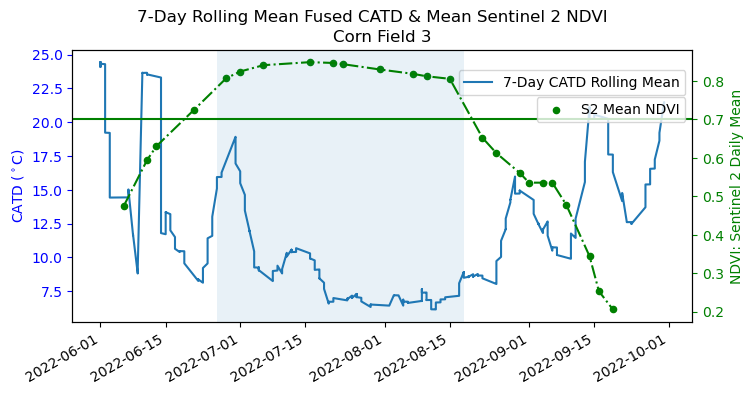

In [19]:
# 17) PLOT AOI Rolling CATD AND NDVI.

# Here we take the starfm fused product, clean it of outliers, and run a rolling mean on it.
# We'll do the same with Sentinel NDVI and plot them together.

# Open up the dataframe csv file.
file_name = "{}_{}_catd_aoi.csv".format(analysis, "starfm_predictions_modis_landsat")
file_path =os.path.join(csv_path, file_name)
df_new_catd = read_df_files(file_path)
df_new_catd.index = df_new_catd['time']

# Get the dataframe out of the list that we are storing it in.
starfm_df = df_new_catd[start1:end1]

# Clean the catd df.  Will take only positive CATD values.  That may not be entirely
# fair, but will do it in this case.
key = "{}_starfm_predictions_modis_landsat_catd".format(analysis)
starfm_clean_df = starfm_df[
    (starfm_df[key] >= 0) & 
    (starfm_df[key] < 25)]

# Create a dual axis figure.
fig, (ax1) = plt.subplots(1,1,figsize=(8, 4))
ax2 = ax1.twinx()

# Plot rolling median
starfm_clean_df[key].rolling(window='7D', min_periods=3).mean().plot(ax=ax1, label='7-Day CATD Rolling Mean')

# Plot NDVI.  First just the points then a dashdot line for visualization.
s2_ndvi_mean_df.index = pd.to_datetime(s2_ndvi_mean_df.time)
s2_ndvi_mean_df[start1:end1].plot.scatter(x='time', y='s2_mean_ndvi',color='green', ax=ax2, label='S2 Mean NDVI')

(sns.lineplot(
            x=s2_ndvi_mean_df[start1:end1].index,
            y=s2_ndvi_mean_df[start1:end1]['s2_mean_ndvi'], 
            ax=ax2, color='green', linestyle='dashdot')
)

# Hard code in vertical shading denoting the .7 NDVI "full vegetation" point.
plt.axvspan('2022-06-26', '2022-08-18', alpha=.1)
# Add line reflecting an ndvi of .7 which we assume is near a fully vegetated state.
ax2.axhline(y=.7, color='green')

fig.suptitle('7-Day Rolling Mean Fused CATD & Mean Sentinel 2 NDVI')
plt.title("Corn Field {}".format(field_num))
# (CATD data is cleaned to include only CATD between 0 and 25.)')

ax1.set_xlabel('')
ax1.set_ylabel('CATD ($^\circ$C)', color='blue')
ax1.tick_params(axis='y', colors='blue')

ax2.set_ylabel('NDVI: Sentinel 2 Daily Mean', color='green')
ax2.tick_params(axis='y', colors='green')

ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.95))
ax2.legend(loc='center right', bbox_to_anchor=(1, .78))

### Section 4:  Extract & Plot data from "stressed" point location.

In [52]:
#* EXTRACT CATD & NDVI POINT DATA FROM DATAARRAYS, CONVERT TO DATAFRAMES, & WRITE FILES.

# Get the starfm da out of our list from before.
catd_starfm_aoi_da = catd_da_list[4]

# The point location of the pixel showing lower ndvi (stress).
point_df = gpd.GeoDataFrame({'geometry':[p_geom]}, crs=CRS.from_epsg(4326))
raster_crs = CRS.from_wkt(ndvi_s2_aoi_ds.spatial_ref.crs_wkt)
buffer_dist = 20 # 1km in local UTM zone
point_poly_df = point_df.to_crs(raster_crs).buffer(buffer_dist, cap_style = 3) # square buffer
centroid = point_poly_df.geometry[0].centroid
point_x, point_y = (centroid.x, centroid.y)

# Select pixel data and convert to dataframe.
ndvi_s2_pnt_df = ndvi_s2_aoi_ds.sel(x=point_x, y=point_y, method='nearest', tolerance=40).to_dataframe('pnt_ndvi')
catd_starfm_pnt_df = catd_starfm_aoi_da.sel(x=point_x, y=point_y, method='nearest', tolerance=40).to_dataframe('pnt_catd')

# Write dfs to files.
ndvi_point_path = write_df_files(ndvi_s2_pnt_df, 'ndvi_point')
catd_point_path = write_df_files(catd_starfm_pnt_df, 'catd_point')

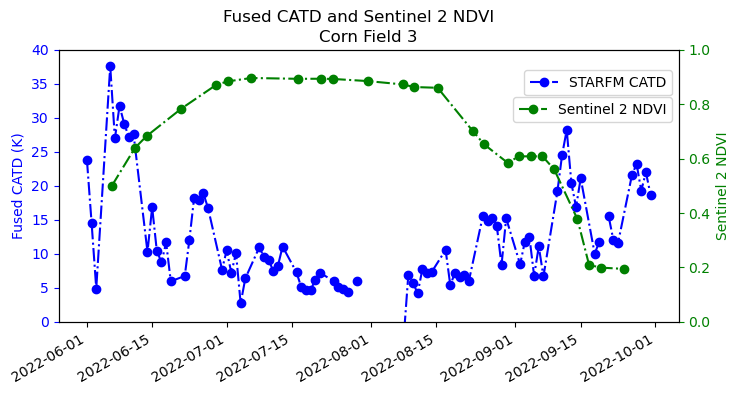

In [21]:
# 18) PLOT USING DATAFRAMES POINT STRESS PIXEL CATD & NDVI.

fig, (ax1) = plt.subplots(1,1,figsize=(8, 4))
ax2 = ax1.twinx()

# Read df csv files into dfs.
file_name = "{}_{}.csv".format(analysis, 'ndvi_point')
ndvi_point_path =os.path.join(csv_path, file_name)

file_name = "{}_{}.csv".format(analysis, 'catd_point')
catd_point_path =os.path.join(csv_path, file_name)

ndvi_s2_pnt_df = read_df_files(ndvi_point_path)
catd_starfm_pnt_df = read_df_files(catd_point_path)

ndvi_s2_pnt_df.plot(x='time', y='pnt_ndvi', color='green', linestyle='dashdot', marker='o', ax=ax2, label='Sentinel 2 NDVI')
catd_starfm_pnt_df.plot(x='time', y='pnt_catd',color='blue', linestyle='dashdot', marker='o', ax=ax1, label='STARFM CATD')

fig.suptitle('Fused CATD and Sentinel 2 NDVI')
plt.title("Corn Field {}".format(field_num))

ax1.set_ylabel('Fused CATD (K)', color='blue')
ax1.set_xlabel('')
ax1.set_ylim(0,40)
ax1.tick_params(axis='y', colors='blue')
    
ax2.set_ylabel(ylabel='Sentinel 2 NDVI', color='green')
ax2.set_ylim(0,1)
ax2.tick_params(axis='y', colors='green')

ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.95))
ax2.legend(loc='center right', bbox_to_anchor=(1, .78))

### Section 5:  Plot met data for the STARFM date/times.

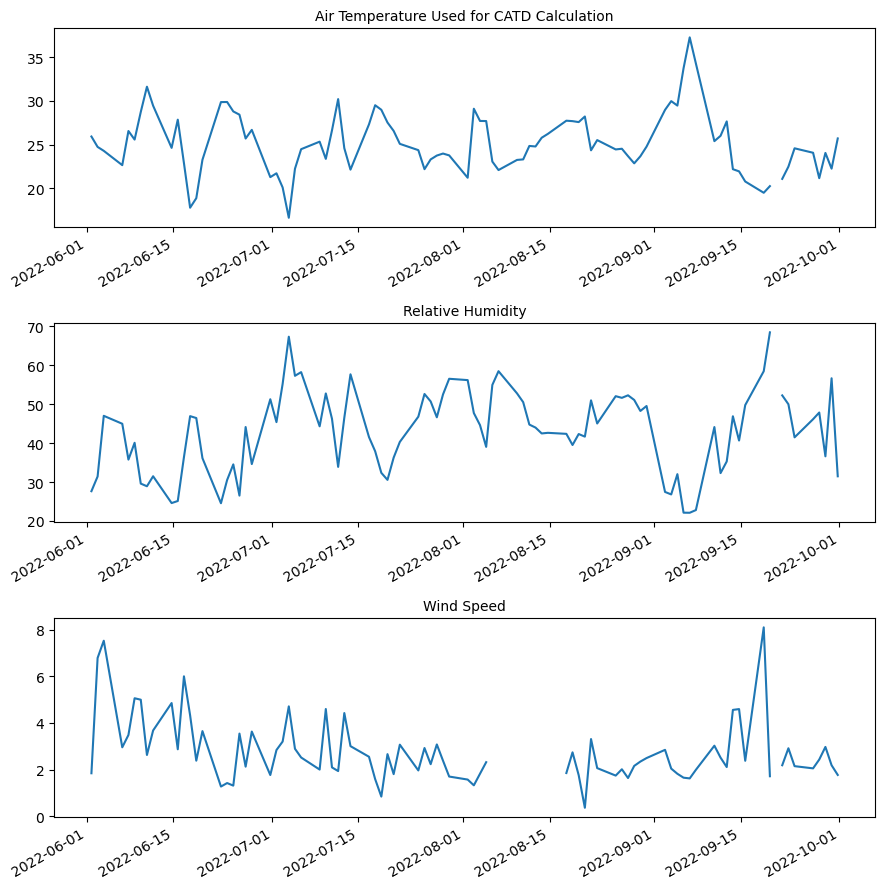

In [22]:
# Extract & Plot Temperature, RH, Wind Speed.

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9))

ta_df.plot(ax=ax1).plot(ax=ax1)
rh_df[start1:end1].plot(ax=ax2)
ws_df[start1:end1].plot(ax=ax3)
#fig.suptitle('Maximum Crop Field Air Temperature')
ax1.set_title('Air Temperature Used for CATD Calculation', fontsize=10)
ax2.set_title('Relative Humidity', fontsize=10)
ax3.set_title('Wind Speed', fontsize=10)
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

plt.tight_layout()